# American Sign Language | Sign Predictor

- Some points about what it is, why are we doing it, how we're gonna do it

Importing Packages

In [18]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import random
from random import sample

import os
import glob
import cv2
import zipfile
import time

Defining Changeable Variables

In [19]:
ROOT_DIR = "dataset/asl_alphabet_train/asl_alphabet_train/"
PIXELSIZE = 32
PIXELTIMES = PIXELSIZE * PIXELSIZE

MAX_IMAGES_PER_CLASS = 500  # Set the maximum number of images per class
TRAIN_SIZE = 14000 # 29 * 220

# Retrieving the Data
Data Link: https://www.kaggle.com/datasets/grassknoted/asl-alphabet

In [20]:
if os.path.exists("archive.zip"):
    print("Data zip exists.")
else:
    print("Download dataset and place in directory!")
    

Data zip exists.


In [21]:
# Create the output directory if it doesn't exist
if not os.path.exists("dataset"):
    os.makedirs("dataset")

    # Open the ZIP file for reading
    with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
        # Extract all the contents of the ZIP file to the output directory
        zip_ref.extractall("dataset")

    print(f'Unzipped archive.zip dataset directory.')

else:
    print("Dataset already exists")

Dataset already exists


# Data Importation and Pre-Processing

In [22]:
image_data = {}

for class_folder in os.listdir(ROOT_DIR):
    class_path = os.path.join(ROOT_DIR, class_folder)
    if os.path.isdir(class_path):
        class_images = []
        for image_file in glob.glob(os.path.join(class_path, "*.jpg")):  # Change the file extension as needed
            class_images.append(image_file)
        image_data[class_folder] = class_images

In [23]:
for class_name, images in image_data.items():
    print(f"Class: {class_name}\tCount: {len(images)}")

Class: A	Count: 3000
Class: B	Count: 3000
Class: C	Count: 3000
Class: D	Count: 3000
Class: del	Count: 3000
Class: E	Count: 3000
Class: F	Count: 3000
Class: G	Count: 3000
Class: H	Count: 3000
Class: I	Count: 3000
Class: J	Count: 3000
Class: K	Count: 3000
Class: L	Count: 3000
Class: M	Count: 3000
Class: N	Count: 3000
Class: nothing	Count: 3000
Class: O	Count: 3000
Class: P	Count: 3000
Class: Q	Count: 3000
Class: R	Count: 3000
Class: S	Count: 3000
Class: space	Count: 3000
Class: T	Count: 3000
Class: U	Count: 3000
Class: V	Count: 3000
Class: W	Count: 3000
Class: X	Count: 3000
Class: Y	Count: 3000
Class: Z	Count: 3000


In [24]:
class_number_dict = {}

images = []
classes = []
classNumber = 0

for class_name, image_paths in image_data.items():
    class_count = 0  # Initialize a counter for the current class
    for image_path in image_paths:
        if isinstance(image_path, str) and os.path.exists(image_path):
            image = cv2.imread(image_path, 0)
            image = cv2.resize(image, (PIXELSIZE, PIXELSIZE), interpolation=cv2.INTER_LINEAR)

            if image is not None:  # Check if the image was successfully loaded
                images.append(image)
                classes.append(classNumber)
                class_count += 1

            if class_count >= MAX_IMAGES_PER_CLASS:
                break  # Stop loading images for the current class

    class_number_dict[class_name] = classNumber
    classNumber += 1

In [25]:
# Combine the two lists into pairs
combined_lists = list(zip(classes, images))

# Shuffle the pairs
random.shuffle(combined_lists)

# Unzip the shuffled pairs back into separate lists
classes, images = zip(*combined_lists)

In [26]:
classes = np.array(classes)
images = np.array(images)

In [27]:
images = images.reshape(-1, PIXELTIMES)

In [28]:
X_train = images[0:TRAIN_SIZE]
y_train = classes[0:TRAIN_SIZE]

X_test = images[TRAIN_SIZE:classes.size]
y_test = classes[TRAIN_SIZE:images.size]

In [29]:
X_train = X_train.T
y_train = y_train.T

X_test = X_test.T
y_test = y_test.T

X_train = X_train / 255.
X_test = X_test / 255.

In [30]:
print(X_train.shape)
print(y_train.shape)

(1024, 14000)
(14000,)


# Exploratory Data Analysis

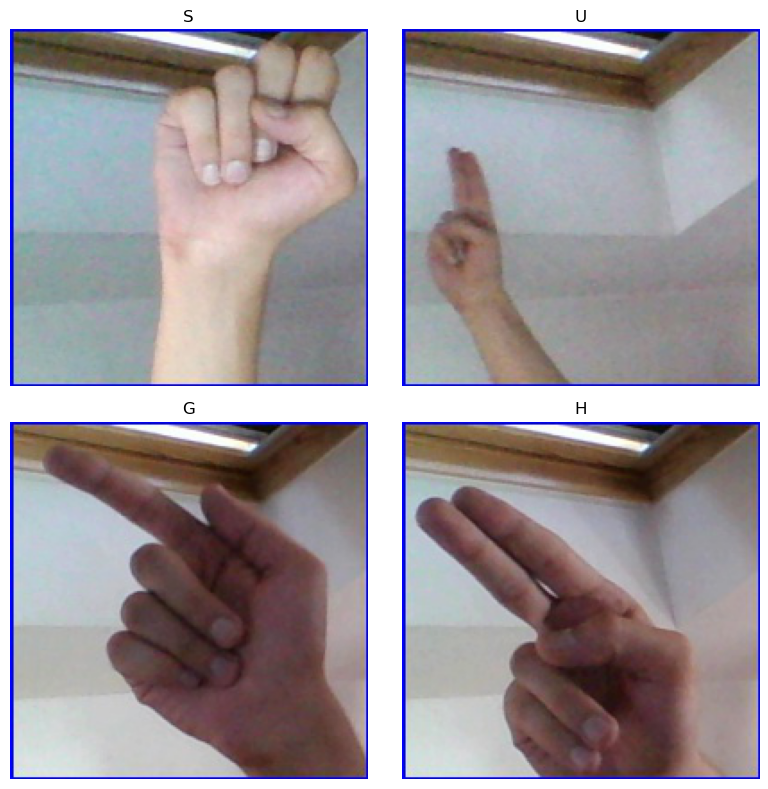

In [31]:
# Select 4 random classes
random_classes = random.sample(list(image_data.keys()), 4)

# Create a 2x2 grid for plotting
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Plot one random image from each class
for i, class_name in enumerate(random_classes):
    row = i // 2
    col = i % 2
    random_image = random.choice(image_data[class_name])
    img = mpimg.imread(random_image)
    axes[row, col].imshow(img)
    axes[row, col].set_title(class_name)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Neural Network Building

In [32]:
def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((TRAIN_SIZE, PIXELSIZE))
    one_hot_Y[np.arange(TRAIN_SIZE), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [33]:
class NeuralNet:
    def __init__(self):
        self.W1 = np.random.rand(PIXELSIZE, PIXELTIMES) - 0.5
        self.B1 = np.random.rand(PIXELSIZE, 1) - 0.5
        self.W2 = np.random.rand(PIXELSIZE, PIXELSIZE) - 0.5
        self.B2 = np.random.rand(PIXELSIZE, 1) - 0.5

    def forward_prop(self, X):
        self.Z1 = self.W1.dot(X) + self.B1
        self.A1 = ReLU(self.Z1)
        self.Z2 = self.W2.dot(self.A1) + self.B2
        self.A2 = softmax(self.Z2)

    def backward_prop(self, X, Y):
        one_hot_Y = one_hot(Y)
        dZ2 = self.A2 - one_hot_Y

        self.dW2 = 1 / TRAIN_SIZE * dZ2.dot(self.A1.T)
        self.db2 = 1 / TRAIN_SIZE * np.sum(dZ2)

        dZ1 = self.W2.T.dot(dZ2) * ReLU_deriv(self.Z1)

        self.dW1 = 1 / TRAIN_SIZE * dZ1.dot(X.T)
        self.db1 = 1 / TRAIN_SIZE * np.sum(dZ1)
        
    def update_params(self, alpha):
        self.W1 = self.W1 - alpha * self.dW1
        self.B1 = self.B1 - alpha * self.db1    
        self.W2 = self.W2 - alpha * self.dW2
        self.B2 = self.B2 - alpha * self.db2

    def train(self, X, Y, alpha, iterations):
        history = []
        start_time = time.time()  # Record the start time

        for i in range(iterations):
            self.forward_prop(X)
            self.backward_prop(X, Y)
            self.update_params(alpha)
        
            if i % 100 == 0:
                acc = np.sum(np.argmax(self.A2, 0) == Y) / Y.size
                history.append([i, acc])
                
                elapsed_time = time.time() - start_time  # Calculate elapsed time in seconds
                elapsed_time_minutes = elapsed_time / 60  # Convert elapsed time to minutes

                print(f"Iteration: {i:>5}\tAccuracy: {acc * 100:.2f}% \tTime elapsed: {elapsed_time_minutes:.2f} minutes")
        return history

    def get_predictions(self, testSet):
        Z1 = self.W1.dot(testSet) + self.B1
        A1 = ReLU(Z1)
        Z2 = self.W2.dot(A1) + self.B2
        A2 = softmax(Z2)
        return np.argmax(A2, 0)
    
    def get_accuracy(self, Xset, Yset):
        return np.sum(self.get_predictions(Xset) == Yset) / Yset.size
    
    def save_model(self, filepath):
        # Create a dictionary to store the weights and biases
        network = {
            'weights_1': self.W1,
            'biases_1': self.B1,
            'weights_2': self.W2,
            'biases_2': self.B2,
            'class_number_dict': class_number_dict
        }

        # Save the weights and biases to a binary file
        np.save(filepath, network)

# Training the Model

In [34]:
nn = NeuralNet()
history = nn.train(X_train, y_train, 0.10, 10000)
nn.save_model('webpage/neural_network_weights.npy')

Iteration:     0	Accuracy: 0.05% 	Time elapsed: 0.00 minutes
Iteration:   100	Accuracy: 3.91% 	Time elapsed: 0.16 minutes
Iteration:   200	Accuracy: 3.73% 	Time elapsed: 0.30 minutes
Iteration:   300	Accuracy: 3.34% 	Time elapsed: 0.43 minutes
Iteration:   400	Accuracy: 6.17% 	Time elapsed: 0.57 minutes
Iteration:   500	Accuracy: 9.07% 	Time elapsed: 0.71 minutes
Iteration:   600	Accuracy: 10.77% 	Time elapsed: 0.84 minutes
Iteration:   700	Accuracy: 13.84% 	Time elapsed: 0.97 minutes
Iteration:   800	Accuracy: 12.12% 	Time elapsed: 1.11 minutes
Iteration:   900	Accuracy: 15.39% 	Time elapsed: 1.24 minutes
Iteration:  1000	Accuracy: 19.27% 	Time elapsed: 1.37 minutes
Iteration:  1100	Accuracy: 19.82% 	Time elapsed: 1.51 minutes
Iteration:  1200	Accuracy: 10.09% 	Time elapsed: 1.64 minutes
Iteration:  1300	Accuracy: 26.64% 	Time elapsed: 1.78 minutes
Iteration:  1400	Accuracy: 22.68% 	Time elapsed: 1.91 minutes
Iteration:  1500	Accuracy: 24.82% 	Time elapsed: 2.05 minutes
Iteration:  16

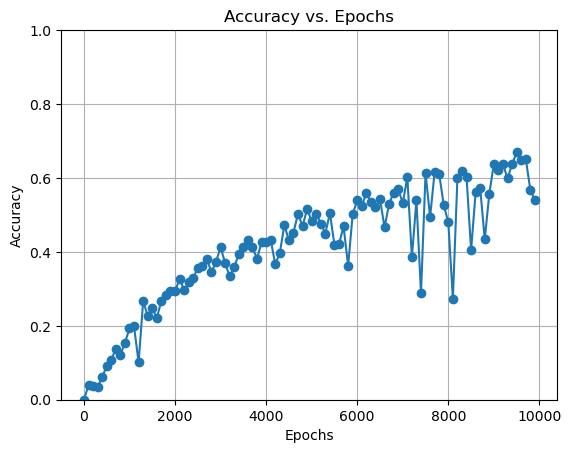

In [35]:
# Create the line graph
plt.plot([item[0] for item in history], [item[1] for item in history], marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.ylim(0, 1)

# Display the graph
plt.grid(True)
plt.show()

# Testing the Model

In [36]:
print(f"Test Accuracy: {nn.get_accuracy(X_test, y_test) * 100:.2f}%")

Test Accuracy: 50.20%


Print predictions on test data

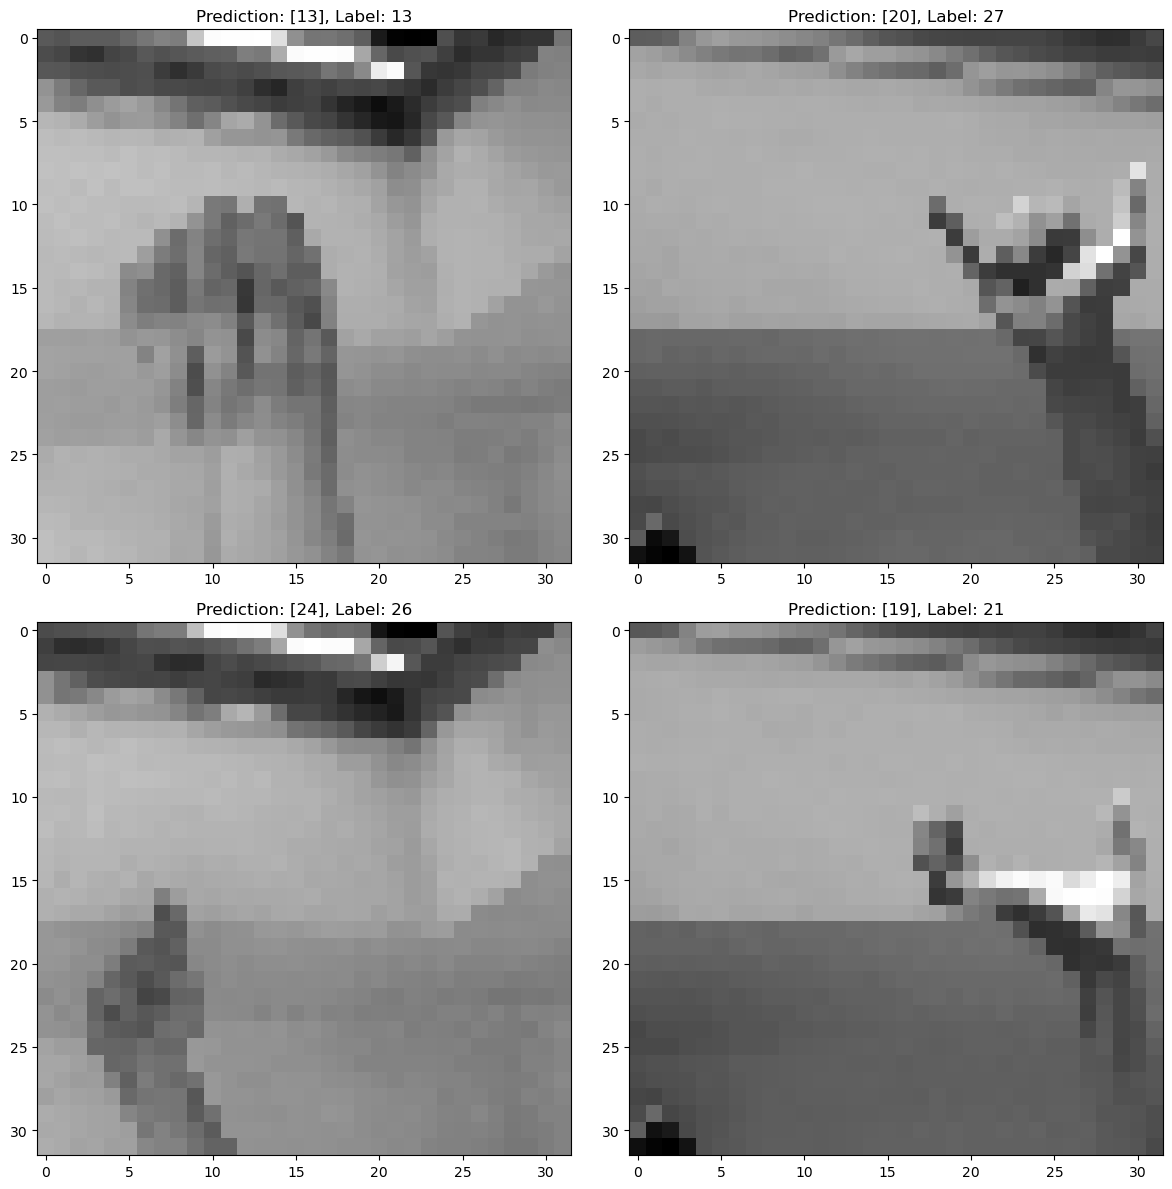

In [37]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Define the indices you want to test
indices = [0, 1, 2, 3]

for i, ax in enumerate(axes.flat):
    if i < len(indices):
        index = indices[i]
        current_image = X_test[:, index, None]
        label = y_test[index]
        prediction = nn.get_predictions(current_image)

        ax.imshow(current_image.reshape((PIXELSIZE, PIXELSIZE)) * 255, interpolation='nearest', cmap='gray')
        ax.set_title(f"Prediction: {prediction}, Label: {label}")
    else:
        ax.axis('off')  # Turn off empty subplots

plt.tight_layout()
plt.show()